## OCR of Captcha Images

Dataset Source: https://www.kaggle.com/datasets/alizahidraja/captcha-data

##### Install Necessary Libraries

In [1]:
%pip install torch torchvision torchaudio
%pip install -q datasets jiwer


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


##### Import Necessary Libraries

In [2]:
import os, sys, itertools
os.environ['TOKENIZERS_PARALLELISM']='false'

import pandas as pd

from PIL import Image

import torch
from torch.utils.data import Dataset

import datasets
from datasets import load_dataset

import transformers
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import VisionEncoderDecoderModel, TrOCRProcessor, default_data_collator

import evaluate

NOTE: Redirects are currently not supported in Windows or MacOs.


##### Display Versions of Relevant Software & Libraries

In [3]:
print("Python:".rjust(15), sys.version[0:6])
print("Pandas:".rjust(15), pd.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Torch:".rjust(15), torch.__version__)

        Python: 3.9.12
        Pandas: 1.4.3
      Datasets: 2.4.0
  Transformers: 4.22.1
         Torch: 1.12.1


##### Ingest & Preprocess Training DataFrame

In [4]:
train_path = "/Users/briandunn/Desktop/Vit Image Datasets/OCR/captcha data/train"
train_dir_list = os.listdir(train_path)

train_dataset = pd.DataFrame(train_dir_list, columns=['file_name'])

train_dataset['text'] = train_dataset['file_name'].map(lambda x: x.split(".")[0])

train_dataset.head()

,file_name,text
0,p5g5m.png,p5g5m
1,e72cd.png,e72cd
2,pgmn2.png,pgmn2
3,6cm6m.png,6cm6m
4,68wfd.png,68wfd


##### Ingest & Preprocess Testing DataFrame

In [5]:
test_path = "/Users/briandunn/Desktop/Vit Image Datasets/OCR/captcha data/test"
test_dir_list = os.listdir(test_path)

test_dataset = pd.DataFrame(test_dir_list, columns=['file_name'])

test_dataset['text'] = test_dataset['file_name'].map(lambda x: x.split(".")[0])

test_dataset.head()

,file_name,text
0,c4527.png,c4527
1,n8ydd.png,n8ydd
2,c6we6.png,c6we6
3,mmg2m.png,mmg2m
4,5nm6d.png,5nm6d


##### Create Dataset Class

In [6]:
class Captcha_Dataset(Dataset):
    
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, padding="max_length", max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id 
                  else -100 for label in labels]
        
        encoding = {"pixel_values" : pixel_values.squeeze(), "labels" : torch.tensor(labels)}
        return encoding

##### Basic Values/Constants

In [7]:
MODEL_CKPT = "microsoft/trocr-base-printed"
MODEL_NAME =  MODEL_CKPT.split("/")[-1] + "_captcha_ocr"
NUM_OF_EPOCHS = 3

##### Instantiate Processor, Create Training, & Testing Dataset Instances

In [8]:
processor = TrOCRProcessor.from_pretrained(MODEL_CKPT)

train_ds = Captcha_Dataset(root_dir="/Users/briandunn/Desktop/Vit Image Datasets/OCR/captcha data/train/",
                             df=train_dataset,
                             processor=processor)

test_ds = Captcha_Dataset(root_dir="/Users/briandunn/Desktop/Vit Image Datasets/OCR/captcha data/test/",
                             df=test_dataset,
                             processor=processor)

##### Print Length of Training & Testing Datasets

In [9]:
print(f"The training dataset has {len(train_ds)} samples in it.")
print(f"The testing dataset has {len(test_ds)} samples in it.")

The training dataset has 856 samples in it.
The testing dataset has 214 samples in it.


##### Example of Input Data Shapes

In [10]:
encoding = train_ds[10]

for k,v in encoding.items():
    print(k, " : ", v.shape)

pixel_values  :  torch.Size([3, 384, 384])
labels  :  torch.Size([128])


##### Show Example

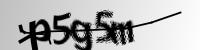

In [11]:
image = Image.open(train_ds.root_dir + train_dataset['file_name'][0]).convert("RGB")

image

##### Show Label for Above Example

In [12]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

37ep6


#### Instantiate Model

In [13]:
model = VisionEncoderDecoderModel.from_pretrained(MODEL_CKPT)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##### Model Configuration Modifications

In [14]:
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id

model.config.vocab_size = model.config.decoder.vocab_size

model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

##### Define Metrics Evaluation

In [15]:
cer_metric = evaluate.load("cer")

def compute_metrics(pred):
    label_ids = pred.label_ids
    pred_ids = pred.predictions
    
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)
    
    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    
    return {"cer" : cer}

##### Define Training Arguments

In [16]:
args = Seq2SeqTrainingArguments(
    output_dir = MODEL_NAME,
    num_train_epochs=NUM_OF_EPOCHS,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_first_step=True,
    hub_private_repo=True,
    push_to_hub=True
)

##### Define Trainer

In [17]:
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=args,
    compute_metrics=compute_metrics,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    data_collator=default_data_collator
)

Cloning https://huggingface.co/DunnBC22/trocr-base-printed_captcha_ocr into local empty directory.


##### Fit/Train Model

In [18]:
trainer.train()

/Users/briandunn/Documents/nlpnn/nlp_ch4/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 856
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 321


  0%|          | 0/321 [00:00<?, ?it/s]

{'loss': 10.4464, 'learning_rate': 4.9844236760124614e-05, 'epoch': 0.01}


***** Running Evaluation *****
  Num examples = 214
  Batch size = 8


  0%|          | 0/27 [00:00<?, ?it/s]

Saving model checkpoint to trocr-base-printed_captcha_ocr/checkpoint-107
Configuration saved in trocr-base-printed_captcha_ocr/checkpoint-107/config.json


{'eval_loss': 0.5615314245223999, 'eval_cer': 0.08785046728971962, 'eval_runtime': 5533.5267, 'eval_samples_per_second': 0.039, 'eval_steps_per_second': 0.005, 'epoch': 1.0}


Model weights saved in trocr-base-printed_captcha_ocr/checkpoint-107/pytorch_model.bin
Feature extractor saved in trocr-base-printed_captcha_ocr/checkpoint-107/preprocessor_config.json
Feature extractor saved in trocr-base-printed_captcha_ocr/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 214
  Batch size = 8


  0%|          | 0/27 [00:00<?, ?it/s]

Saving model checkpoint to trocr-base-printed_captcha_ocr/checkpoint-214
Configuration saved in trocr-base-printed_captcha_ocr/checkpoint-214/config.json


{'eval_loss': 0.24318334460258484, 'eval_cer': 0.026168224299065422, 'eval_runtime': 4970.2478, 'eval_samples_per_second': 0.043, 'eval_steps_per_second': 0.005, 'epoch': 2.0}


Model weights saved in trocr-base-printed_captcha_ocr/checkpoint-214/pytorch_model.bin
Feature extractor saved in trocr-base-printed_captcha_ocr/checkpoint-214/preprocessor_config.json
Feature extractor saved in trocr-base-printed_captcha_ocr/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 214
  Batch size = 8


  0%|          | 0/27 [00:00<?, ?it/s]

Saving model checkpoint to trocr-base-printed_captcha_ocr/checkpoint-321
Configuration saved in trocr-base-printed_captcha_ocr/checkpoint-321/config.json


{'eval_loss': 0.13803276419639587, 'eval_cer': 0.007476635514018692, 'eval_runtime': 5028.1446, 'eval_samples_per_second': 0.043, 'eval_steps_per_second': 0.005, 'epoch': 3.0}


Model weights saved in trocr-base-printed_captcha_ocr/checkpoint-321/pytorch_model.bin
Feature extractor saved in trocr-base-printed_captcha_ocr/checkpoint-321/preprocessor_config.json
Feature extractor saved in trocr-base-printed_captcha_ocr/preprocessor_config.json
Adding files tracked by Git LFS: ['.DS_Store']. This may take a bit of time if the files are large.


Training completed. Do not forget to share your model on huggingface.co/models =)




{'train_runtime': 54834.3401, 'train_samples_per_second': 0.047, 'train_steps_per_second': 0.006, 'train_loss': 0.40612717209575333, 'epoch': 3.0}


TrainOutput(global_step=321, training_loss=0.40612717209575333, metrics={'train_runtime': 54834.3401, 'train_samples_per_second': 0.047, 'train_steps_per_second': 0.006, 'train_loss': 0.40612717209575333, 'epoch': 3.0})

##### Save Model & Model State

In [21]:
trainer.save_model()
trainer.save_state()

Saving model checkpoint to trocr-base-printed_captcha_ocr
Configuration saved in trocr-base-printed_captcha_ocr/config.json
Model weights saved in trocr-base-printed_captcha_ocr/pytorch_model.bin
Feature extractor saved in trocr-base-printed_captcha_ocr/preprocessor_config.json
Saving model checkpoint to trocr-base-printed_captcha_ocr
Configuration saved in trocr-base-printed_captcha_ocr/config.json
Model weights saved in trocr-base-printed_captcha_ocr/pytorch_model.bin
Feature extractor saved in trocr-base-printed_captcha_ocr/preprocessor_config.json


##### Evaluate Model

In [19]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 214
  Batch size = 8


  0%|          | 0/27 [00:00<?, ?it/s]

{'eval_loss': 0.13803276419639587,
 'eval_cer': 0.007476635514018692,
 'eval_runtime': 5008.3445,
 'eval_samples_per_second': 0.043,
 'eval_steps_per_second': 0.005,
 'epoch': 3.0}

##### Push Model to Hub (My Profile!!!)

In [20]:
kwargs = {
    "finetuned_from" : model.config._name_or_path,
    "tasks" : "image-to-text",
    "tags" : ["image-to-text"],
}

if args.push_to_hub:
    trainer.push_to_hub("All Dunn!!!")
else:
    trainer.create_model_card(**kwargs)

Saving model checkpoint to trocr-base-printed_captcha_ocr
Configuration saved in trocr-base-printed_captcha_ocr/config.json
Model weights saved in trocr-base-printed_captcha_ocr/pytorch_model.bin
Feature extractor saved in trocr-base-printed_captcha_ocr/preprocessor_config.json


Upload file runs/Jan12_22-58-23_Brians-Mac-mini.local/events.out.tfevents.1673585911.Brians-Mac-mini.local.438…

Upload file runs/Jan12_22-58-23_Brians-Mac-mini.local/events.out.tfevents.1673645753.Brians-Mac-mini.43820.2: …

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/trocr-base-printed_captcha_ocr
   c0145d1..a66a6da  main -> main

To https://huggingface.co/DunnBC22/trocr-base-printed_captcha_ocr
   a66a6da..7cc8af5  main -> main



### Notes & Other Takeaways From This Project
****
- The Character Error Rate (CER) was 0.0075. I am pleased with that result.
- Context about metric: Zero (0) is perfection. One the worst score (unless there is an insertion error).
****

### Citations

##### For Transformer Checkpoint
- @misc{li2021trocr,
      title={TrOCR: Transformer-based Optical Character Recognition with Pre-trained Models}, 
      author={Minghao Li and Tengchao Lv and Lei Cui and Yijuan Lu and Dinei Florencio and Cha Zhang and Zhoujun Li and Furu Wei},
      year={2021},
      eprint={2109.10282},
      archivePrefix={arXiv},
      primaryClass={cs.CL}
}

##### For CER Metric
- @inproceedings{morris2004,
author = {Morris, Andrew and Maier, Viktoria and Green, Phil},
year = {2004},
month = {01},
pages = {},
title = {From WER and RIL to MER and WIL: improved evaluation measures for connected speech recognition.}
}